# Introduction

Machine learning has a phenomenal range of applications, including in health and diagnostics. Deep learning is a subset of machine learning, which follows the neural network algorithm and tries to copy how the brain works. Using Deep Learning on Chest X-Ray images, we can classify if a particular sample patient has Pneumonia or not. This is especially useful during these current times as COVID-19 is known to cause pneumonia.

We will build an X-ray image classification model from scratch to predict whether an X-ray scan shows presence of pneumonia. The Neural Network model architecture will consist of Convolutional blocks (with Max Pooling, dropout, Batch Normalization) and dense layers with Sigmoid activation function at the end for getting the classification.
We will load in image data, build and train a convolution neural network, finetune and regularize the model, and predict results.
Data augmentation is not included in the model because X-ray scans are only taken in a specific orientation, and variations such as flips and rotations will not exist in real X-ray images.
We will make use of Python language, and libraries like Tensorflow, Scikit-Learn.

# Importing Libraries & setting up TPU/GPU

In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

2022-12-01 20:23:16.778272: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-01 20:23:16.778433: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Device: grpc://10.0.0.2:8470


2022-12-01 20:23:24.023268: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-01 20:23:24.026916: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-01 20:23:24.026958: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-01 20:23:24.026982: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (07d4522ecee7): /proc/driver/nvidia/version does not exist
2022-12-01 20:23:24.030657: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8
2.4.1


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25

# Load the data & Re-split

In [3]:
GCS_PATH

'gs://kds-b1967aa877e88620007e672d0a3f5c3ac1ac7760d56fb24898045994'

In [4]:
filenames = tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/train/*/*'))  
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

2022-12-01 20:24:46.416826: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-01 20:24:46.504071: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-01 20:24:46.596618: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-01 20:24:46.663098: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-01 20:24:46.755100: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [5]:
len(train_filenames), len(val_filenames)

(4185, 1047)

Run the following cell to see how many healthy/normal chest X-rays we have and how many pneumonia chest X-rays we have.

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1087
Pneumonia images count in training set: 3098


# Create TF dataloader

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'gs://kds-b1967aa877e88620007e672d0a3f5c3ac1ac7760d56fb24898045994/chest_xray/train/PNEUMONIA/person1477_virus_2561.jpeg'
b'gs://kds-b1967aa877e88620007e672d0a3f5c3ac1ac7760d56fb24898045994/chest_xray/train/PNEUMONIA/person275_bacteria_1294.jpeg'
b'gs://kds-b1967aa877e88620007e672d0a3f5c3ac1ac7760d56fb24898045994/chest_xray/train/NORMAL/NORMAL2-IM-1201-0001.jpeg'
b'gs://kds-b1967aa877e88620007e672d0a3f5c3ac1ac7760d56fb24898045994/chest_xray/train/PNEUMONIA/person1372_bacteria_3501.jpeg'
b'gs://kds-b1967aa877e88620007e672d0a3f5c3ac1ac7760d56fb24898045994/chest_xray/train/PNEUMONIA/person1544_bacteria_4035.jpeg'


2022-12-01 20:25:31.439047: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 26, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1669926331.435687404","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 26, Output num: 0","grpc_status":3}


In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [9]:
CLASS_NAMES = []
for item in tf.io.gfile.glob(str(GCS_PATH + "/chest_xray/train/*")):
    classname = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]])
    CLASS_NAMES.append(classname)
    
CLASS_NAMES

2022-12-01 20:25:43.847824: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-01 20:25:43.906816: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-01 20:25:43.979242: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-01 20:25:44.036647: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-01 20:25:44.120550: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


[array(['NORMAL'], dtype='<U6'), array(['PNEUMONIA'], dtype='<U9')]

As expected, we have two labels for our images.

Currently our dataset is just a list of filenames. We want to map each filename to the corresponding (image, label) pair.

As we only have two labels, we will rewrite the label so that `1` or `True` indicates pneumonia and `0` or `False` indicates normal.

The images originally have values that range from [0, 255]. CNNs work better with smaller numbers so we will scale this down.

In [10]:
def get_label(file_path):
    # get label from file path
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# Shape of a sample

Let's visualize the shape of 5 (image, label) pair.

In [12]:
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True


2022-12-01 20:31:36.782065: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 183, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1669926696.781950272","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 183, Output num: 1","grpc_status":3}


True means that the image is of Pneumonia, and false means it is a normal image.

# Loading & Creating TF dataloader of Test dataset

Load and format the test data as well.

In [13]:
test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

# Batching & shuffling the dataloader objects

In [14]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):  # if cache is of type string ->
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE) # prefetch lets the dataset fetch batches in the background while the model is training.

    return ds

Create the data loader that is batched and shuffled

In [15]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Visualization of a batch

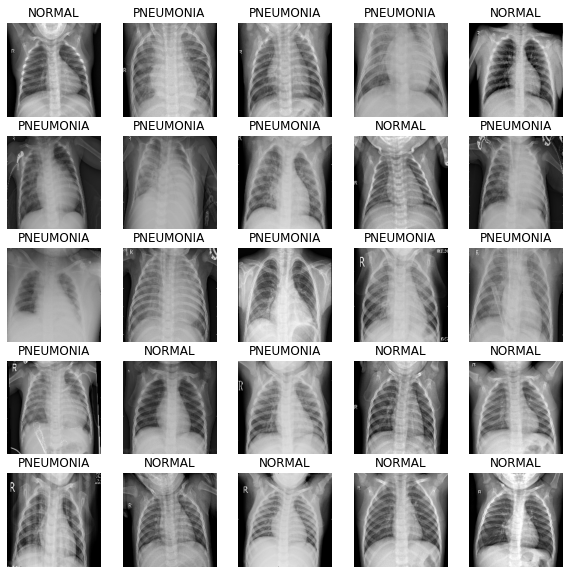

In [16]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
        

image_batch, label_batch = next(iter(train_ds))
        
show_batch(image_batch.numpy(), label_batch.numpy())

# Build the CNN Model architecture

To make our model more modular and easier to understand, let's define some blocks. As we're building a convolution neural network, we'll create a convolution block and a dense layer block.

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Train the model

Since there are only two possible labels for the image, we will be using the `binary_crossentropy` loss. When we fit the model, identify the class weights.

For our metrics, we want to include precision and recall as they will provide use with a more informed picture of how good our model is. Accuracy tells us what fractions are the labels are correct

Precision is the number of true positives (TP) over the sum of TP and false positives (FP). It shows what fraction of labeled positives are actually correct.

Recall is the number of TP over the sum of TP and false negatves (FN). It shows what fraction of actual positives are correct.

In [19]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [20]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=40,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
)

Epoch 1/40
32/32 [==============================] - 165s 4s/step - loss: 0.6770 - accuracy: 0.6581 - precision: 0.8539 - recall: 0.6432 - val_loss: 0.6156 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 2/40
32/32 [==============================] - 3s 86ms/step - loss: 0.3453 - accuracy: 0.8819 - precision: 0.9584 - recall: 0.8787 - val_loss: 0.5638 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 3/40
32/32 [==============================] - 3s 86ms/step - loss: 0.2664 - accuracy: 0.9182 - precision: 0.9620 - recall: 0.9283 - val_loss: 0.6203 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 4/40
32/32 [==============================] - 3s 86ms/step - loss: 0.1897 - accuracy: 0.9433 - precision: 0.9682 - recall: 0.9552 - val_loss: 0.7028 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 5/40
32/32 [==============================] - 3s 86ms/step - loss: 0.1912 - accuracy: 0.9381 - precisi

# 8. Visualizing model performance

Let's plot the model accuracy and loss for the training and the validating set. These plots show the accuracy and loss values for the second round of training. Since we initially trained the model with 30 epochs, these would be epochs 31-45. Note that no random seed is specified for this notebook. For your notebook, there might be slight variance.

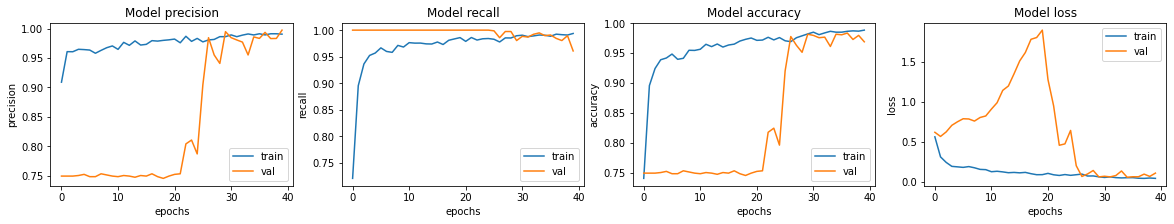

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

We see that the accuracy for our model is around 98%. Finetune the model further to see if we can achieve a higher accuracy.

# Predict and evaluate results

Evaluate the model on our test data

In [22]:
loss, acc, prec, rec = model.evaluate(test_ds)

5/5 [==============================] - 25s 4s/step - loss: 0.5905 - accuracy: 0.8397 - precision: 0.8085 - recall: 0.9744


We see that our accuracy on our test data is 83%, which is lower than the accuracy for our validating set. This may indicate overfitting. 

Our recall is greater than our precision, indicating that almost all pneumonia images are correctly identified but some normal images are falsely identified. We should aim to increase our precision.

# Fine-Tuning

To improve our model, we can try removing the imbalance in class labels. Also, we can use Learning Rate schedulers like exponential decay to tune the LR as epochs increase. Also using Early Stopping will be helpful, so that we save the best model and stop when loss stops decreasing.
